In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from itertools import product
from matplotlib import pyplot
from matplotlib import pyplot
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FormatStrFormatter
from entropyLibDC import *
import pickle 
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [2]:
# Plot function
def box_violin(sequences,x_interval,sequence_title,edge_colors,face_colors,ylim,r=2,c=3,ytitle='Values',xtitle='Steps',ylog=False,figsize=(18, 6)):
    k=len(sequences)
    id_list=[[i,j] for i in range(r) for j in range(c)]
    fig, axs = plt.subplots(r, c, figsize=figsize, dpi=144)  # Create a 3x1 grid of subplots

    for i, sequence in enumerate(sequences):
        rcid=id_list[i]
        ax = axs[rcid[0],rcid[1]]  # Select the subplot
        
        # Scatter plot
        ax.scatter(x_interval, sequence.mean(0), edgecolors=edge_colors[i], c='white',label='Mean',s=20,zorder=10,alpha=1)
        
        # Violin plots
        for t in range(sequence.shape[-1]):
            violin = ax.violinplot(sequence[:,t], positions=[x_interval[t]], showmeans=False, showextrema=False, widths=0.9)
            for pc in violin['bodies']:
                pc.set_facecolor(face_colors[i])
            boxprops = dict(color='k',linewidth=0.8)
            medianprops = dict(color='k',linewidth=0.8)
            capprops= dict(color='k',linewidth=0.8)
            boxs=ax.boxplot(sequence[:,t], positions=[x_interval[t]], showfliers=False, showmeans=False, widths=0.75,\
                            boxprops=boxprops,medianprops=medianprops,capprops=capprops,whiskerprops=capprops, )
        
        # Setting the labels and ticks
        ax.set_ylabel(ytitle)
        ax.set_xticks([int(x) for x in x_interval])
        #ax.set_ylim([-2000, 30000])  # Uncomment and adjust as necessary
        ax.set_xlabel(xtitle)
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        #ax.set_ylim(ylim)
        if ylog:
            ax.set_yscale('log')
            locator = LogLocator(base=10.0, subs=[2, 3, 4,5, 6,7, 8], numticks=24)
            ax.yaxis.set_minor_locator(locator)
        ax.grid(alpha=0.2,which='both')
        #ax.legend(loc=2)
        ax.set_title(sequence_title[i])
    for j in range(i+1,len(id_list)):
        rcid=id_list[j]
        axs[rcid[0],rcid[1]].set_axis_off()
    plt.tight_layout()
    plt.close(fig)
    return fig

In [3]:
def Conditional_MI(ytp1, xttau, yttau, n=16, buffer_coefficient=0.3, e=1e-12):
    """
    Calculate the conditional mutual information I(ytp1; xttau | yttau).

    Parameters:
    ytp1 : array_like 
        Future state of sequence y. => y_{t+1}
    xttau : array_like 
        Past states of sequence x. => x_t^tau
    yttau : array_like
        Past states of sequence y. => y_t^tau
    n : int, optional
        Number of Gauss points for numerical integration.
    buffer_coefficient : float, optional
        Coefficient to determine the buffer around the range of data for KDE.
    e : float, optional
        Small constant to prevent log of zero.

    Returns:
    float
        The calculated conditional mutual information.
    """

    # Concatenate arrays for joint distributions and create KDEs
    big_joint = np.hstack([ytp1, xttau, yttau])
    small_j1 = np.hstack([ytp1, yttau])
    small_j2 = np.hstack([xttau, yttau])
    kde_bj = stats.gaussian_kde(big_joint.T)
    kdey_tau = stats.gaussian_kde(yttau.T)
    kde_s1 = stats.gaussian_kde(small_j1.T)
    kde_s2 = stats.gaussian_kde(small_j2.T)
    # Calculate Gauss points and weights
    upper, lower = big_joint.max(0), big_joint.min(0)
    buffer = buffer_coefficient * (upper - lower)
    # Assuming GLJointNW_general is defined elsewhere
    glpw, _ = GLJointNW_general(N=[n] * big_joint.shape[-1], Lower=lower-buffer, Upper=upper+buffer)

    # Extract points and weights for each distribution
    d_ytp1, d_xtau, d_ytau = [ytp1.shape[-1], xttau.shape[-1], yttau.shape[-1]]
    gauss_bigjoint = glpw[:, :-1]
    gaussp_ytau = glpw[:, d_ytp1+d_xtau:d_ytp1+d_xtau+d_ytau] # y_t^tau
    gauss_sj1 = np.hstack([glpw[:, :d_ytp1], gaussp_ytau]) # [y_{t+1},y_t^tau]
    gauss_sj2 = np.hstack([glpw[:, d_ytp1:d_ytp1+d_xtau], gaussp_ytau]) #[x_t^tau, y_t^tau]


    w = glpw[:, -1]  # Gauss weights
    # Evaluate KDEs at the Gauss points
    pbj = kde_bj(gauss_bigjoint.T)
    pytau = kdey_tau(gaussp_ytau.T)
    ps1 = kde_s1(gauss_sj1.T)
    ps2 = kde_s2(gauss_sj2.T)
    # Regularize probabilities
    pbj, pytau, ps1, ps2 = [np.maximum(arr, e) for arr in [pbj, pytau, ps1, ps2]]
    
    # Compute and return the conditional mutual information
    conditional_MI = (pbj * (np.log2(pytau) + np.log2(pbj) - np.log2(ps1) - np.log2(ps2)) * w).sum()
    return conditional_MI

def TEttau(source,target,t,tau,n=16):
    """
    Calculates the transfer entropy from the source sequence to the target sequence at a specific observed time step `t`,
    considering a past history of length `tau`. This function uses a numerical integration method with `n` Gauss points.

    Inputs:
      - source, target: Two arrays of shape (N, T), where N is the number of observations and T is the number of time steps.
      - t: The current observed time step for which the transfer entropy is being calculated.
      - tau: The length of past history to consider for calculating transfer entropy.
      - n: The number of Gauss points used for numerical integration in the entropy calculation.

    Output:
      - TEint: A scalar value representing the transfer entropy from `source` to `target` at the specified time step `t`.
    """
    ytp1=target[:,[t+1]]
    yttau=target[:,t-tau+1:t+1]
    xttau=source[:,t-tau+1:t+1]
    TEint=Conditional_MI(ytp1,xttau,yttau,n=n)
    return TEint


def Transfer_Entropy_Sequence(source,target,tau=1,n=16):
    """
    Computes a sequence of transfer entropy values from the source sequence to the target sequence for a series of
    observed time steps. This calculation takes into account a specified past history length (`tau`) and performs numerical
    integration using a given number of Gauss points (`n`). This function is designed to evaluate the dynamic transfer of
    information between the two sequences over time.

    Inputs:
      - source, target: Two numpy arrays of shape (N, T), where N represents the number of observations and T the total number
        of time steps, indicating the source and target sequences, respectively.
      - tau: An integer indicating the length of the past history to consider in the transfer entropy calculation, allowing
        for the assessment of temporal dependencies over the specified length.
      - n: The number of Gauss points used for the numerical integration, impacting the accuracy and computational demand of
        the entropy calculations.

    Outputs:
      - Transfer entropy sequence: A numpy array containing the calculated transfer entropy values for each time step from `tau`
        to `T-1`, illustrating how information flow from source to target evolves over time.
      - t_interval: A numpy array of observation steps corresponding to each transfer entropy value, useful for plotting and
        analysis, indicating the time steps at which transfer entropy was computed.

    Note: The function ensures that transfer entropy values are strictly non-negative by applying a minimum threshold of 1e-12,
    avoiding numerical issues with logarithms and zero values.
    """
    T=source.shape[-1]
    transfer_entropy_values=[]
    t_interval=[]

    for t in range(tau-1,T-1):
        TEint=TEttau(source,target,t,tau,n)
        transfer_entropy_values.append(TEint)
        t_interval.append(t+1)
    transfer_entropy_values=np.array(transfer_entropy_values)
    transfer_entropy_values=np.maximum(transfer_entropy_values,1e-12)
    return transfer_entropy_values, t_interval

# Formulate Sequences

In [100]:

# Sequence 1
sequence_len=20
noise1=3*np.random.rand(100,sequence_len)+5*np.random.randn(100,sequence_len)*np.linspace(0.5,sequence_len*0.15,sequence_len)
sigmoid_base1=np.linspace(-5,10,sequence_len)
mean=sigmoid(sigmoid_base1)*100
x=mean+noise1


# Sequence 2
sigmoid_base2=np.linspace(-5,15,sequence_len)
mean=-sigmoid(sigmoid_base2)
mean=(mean-mean.min())/(mean.max()-mean.min())*100
noise2=3*np.random.rand(100,sequence_len)*np.linspace(0.5,sequence_len*0.15,sequence_len)-5*np.random.randn(100,sequence_len)*np.linspace(0.5,sequence_len*0.15,sequence_len)
y1=mean+noise2
y1=(-x-5*np.random.randn(100,sequence_len)*np.linspace(0.5,sequence_len*0.15,sequence_len))
#y1 = np.array([np.random.rand(x.shape[0]) if t == 0 else -x[:, t-1]**2*0.02 + 5*np.random.rand(1) for t in range(x.shape[1])]).T

#Sequence 3: First Order
#y2=np.array([np.random.rand(x.shape[0]) if t == 0 else (x[:, t-1]*2+x[:, t-1]*x[:, t]- 5*np.abs(np.random.randn(1))) for t in range(x.shape[1])]).T

# Sequence 4: 2nd order polynomial
#y3=np.array([np.random.rand(x.shape[0]) if t == 0 else (x[:, t-1]**2+x[:, t-1]*x[:, t] + 10*np.abs(np.random.randn(1)))/(t**2) for t in range(x.shape[1])]).T

# Sequence 5: 3rd order polynomial
#y4=np.array([np.random.rand(x.shape[0]) if t == 0 else (x[:, t-1]**3-5*x[:, t-1]*x[:, t] + 15*np.abs(np.random.randn(1)))/(t**3) for t in range(x.shape[1])]).T

# Sequence 6: Independent

sin_mean=50#*sigmoid_base1#50*np.sin(5*sigmoid_base1)
noise6=5*np.random.rand(100,sequence_len)**2-6*np.random.randn(100,sequence_len)
z=sin_mean+noise6



array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

In [101]:
y2=[]
y3=[]
y4=[]
for t in range(x.shape[1]):
    if t==0:
        y2.append(np.random.rand(x.shape[0]))
        y3.append(np.random.rand(x.shape[0]))
        y4.append(np.random.rand(x.shape[0]))
    else:
        y2.append( x[:, t-1]*2-0.002*y2[t-1]*x[:, t-1]+ 5*np.abs(np.random.randn(1)) )
        y3.append( (x[:, t-1]**2-0.2*y2[t-1]*x[:, t-1] + 10*np.abs(np.random.randn(1)))/(t**2) )
        y4.append( (x[:, t-1]**3+x[:, t-1]**2-y2[t-1]*x[:, t-1] + 15*np.abs(np.random.randn(1)))/(t**3) )
y2=np.stack(y2).T
y3=np.stack(y3).T
y4=np.stack(y4).T

In [143]:
save=False
if save:
    source=x
    targets=[y1,y2,y3,y4,z]
    Experiment_data={'Source':source,'Targets':targets}


    with open('TE_experiments_sequences.pkl', 'wb') as f:
        pickle.dump(Experiment_data, f)



# Load the sequential data

In [4]:
Experiment_data=np.load('TE_experiments_sequences.pkl',allow_pickle=True)
x=Experiment_data['Source']
source=x
targets=Experiment_data['Targets']
y1,y2,y3,y4,z=targets

sequence_len=x.shape[-1]
t_=np.linspace(1,sequence_len,sequence_len)


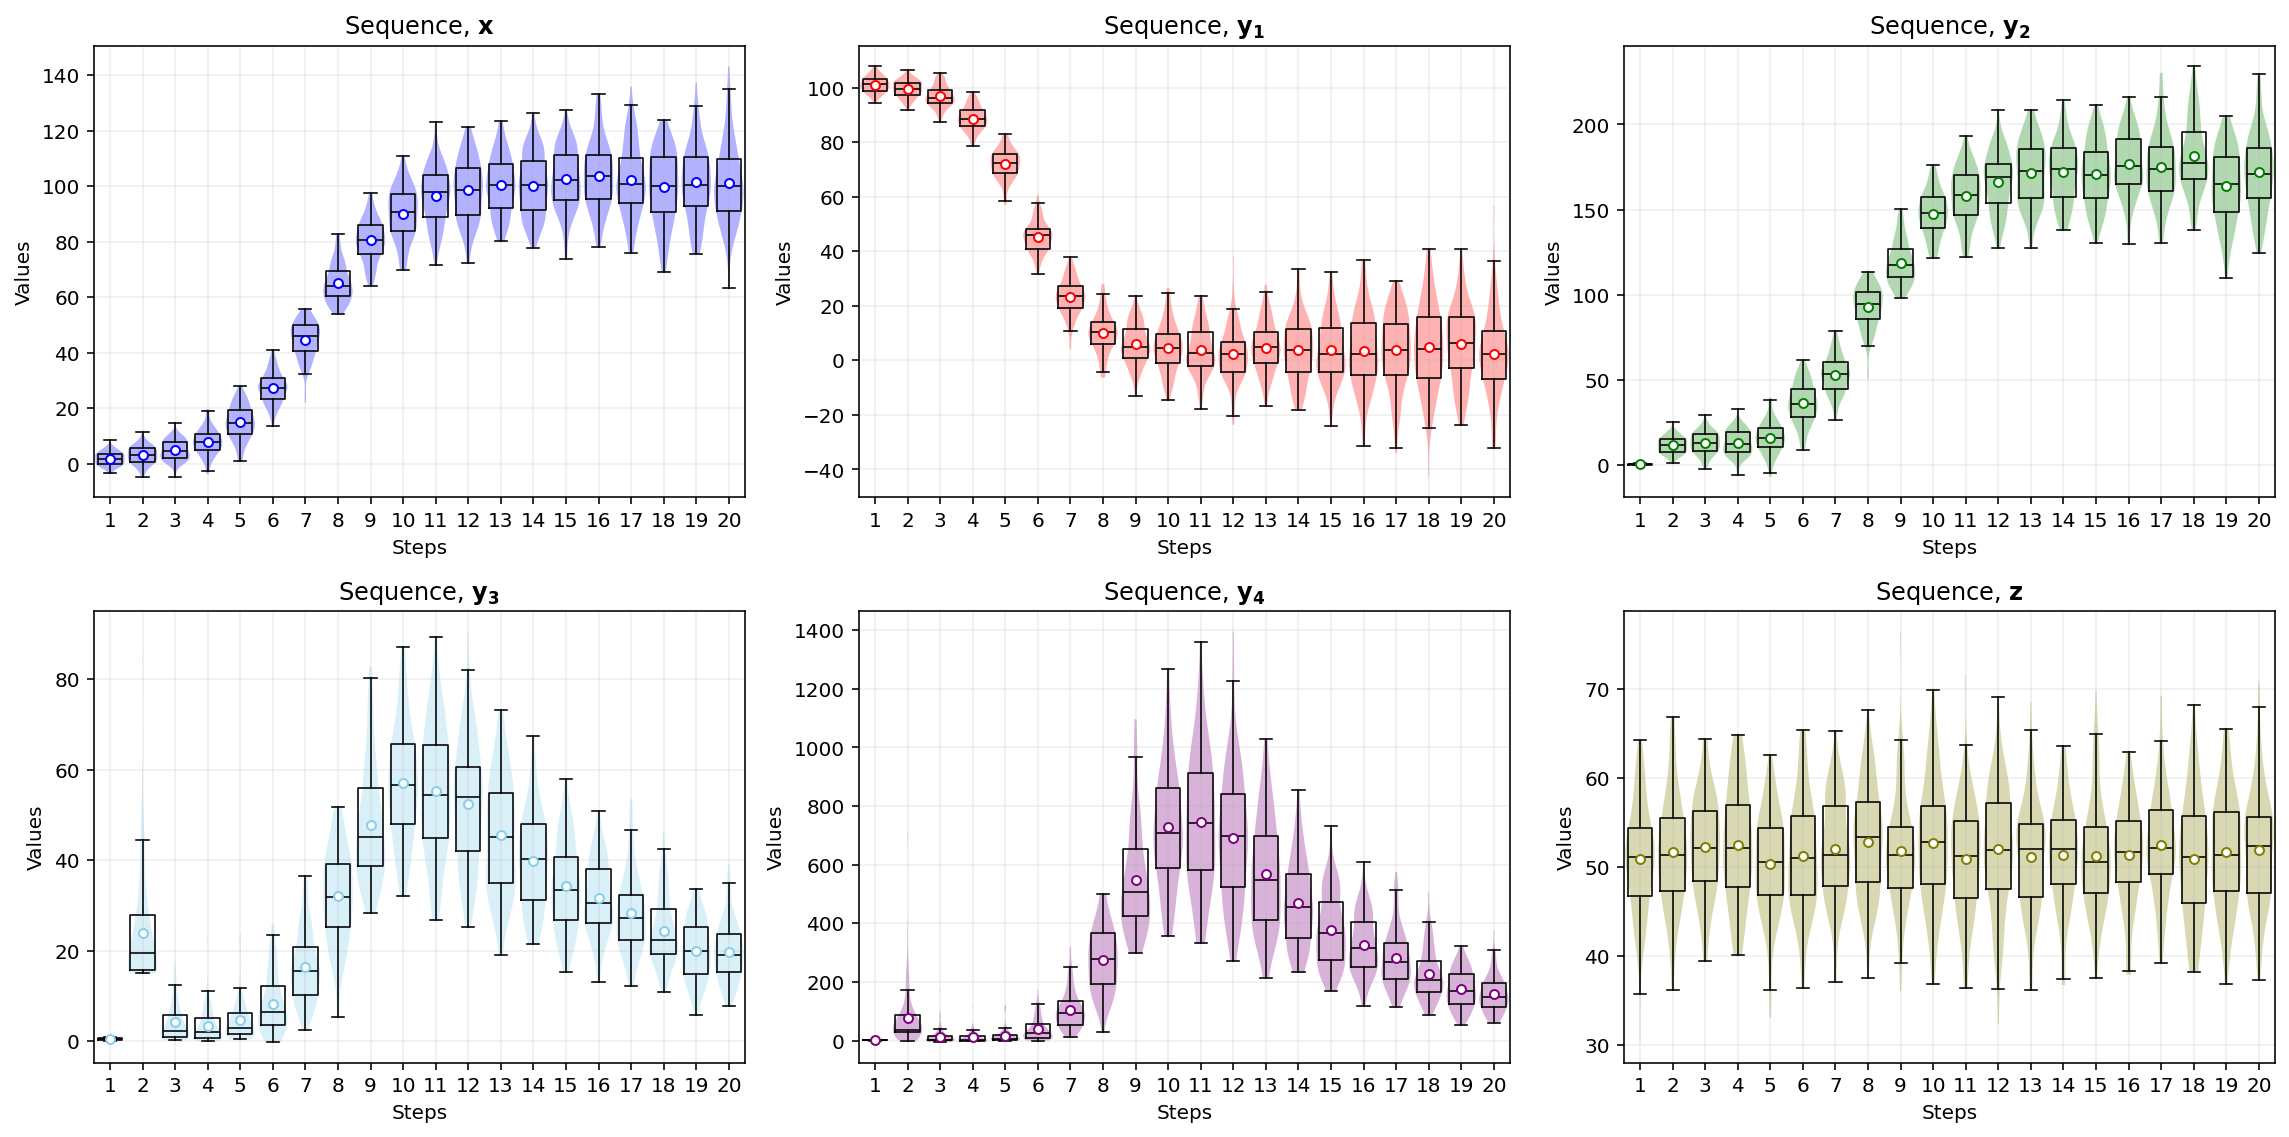

In [5]:
box_violin(sequences=[x,y1,y2,y3,y4,z]
           ,x_interval=t_
           ,sequence_title=[r'Sequence, $\mathbf{x}$',r'Sequence, $\mathbf{y_1}$',r'Sequence, $\mathbf{y_2}$',r'Sequence, $\mathbf{y_3}$',r'Sequence, $\mathbf{y_4}$',r'Sequence, $\mathbf{z}$']
           ,edge_colors=['blue','red','green','skyblue','purple','olive'],face_colors=['blue','red','green','skyblue','purple','olive']
           ,ylim=[],ytitle='Values',xtitle='Steps',ylog=False,figsize=(16, 8))

# Experiment 1: Directionality, History Length, and Temporal Correlation Effects

In [18]:

TE_pairs=[]
tau=1
for target in targets:
    TE,t_interest=Transfer_Entropy_Sequence(source,target,tau=tau,n=16)
    TE_inv,_=Transfer_Entropy_Sequence(target,source,tau=tau,n=16)
    TE_pairs.append([TE,TE_inv])

In [19]:
seq_names=[r'\mathbf{x}',r'\mathbf{y_1}',r'\mathbf{y_2}',r'\mathbf{y_3}',r'\mathbf{y_4}',r'\mathbf{z}']
titles=[[seq_names[0],j] for j in seq_names[1:]]

In [20]:

with open('TEs_tau'+str(tau)+'.pkl', 'wb') as f:
    pickle.dump(TE_pairs, f)    

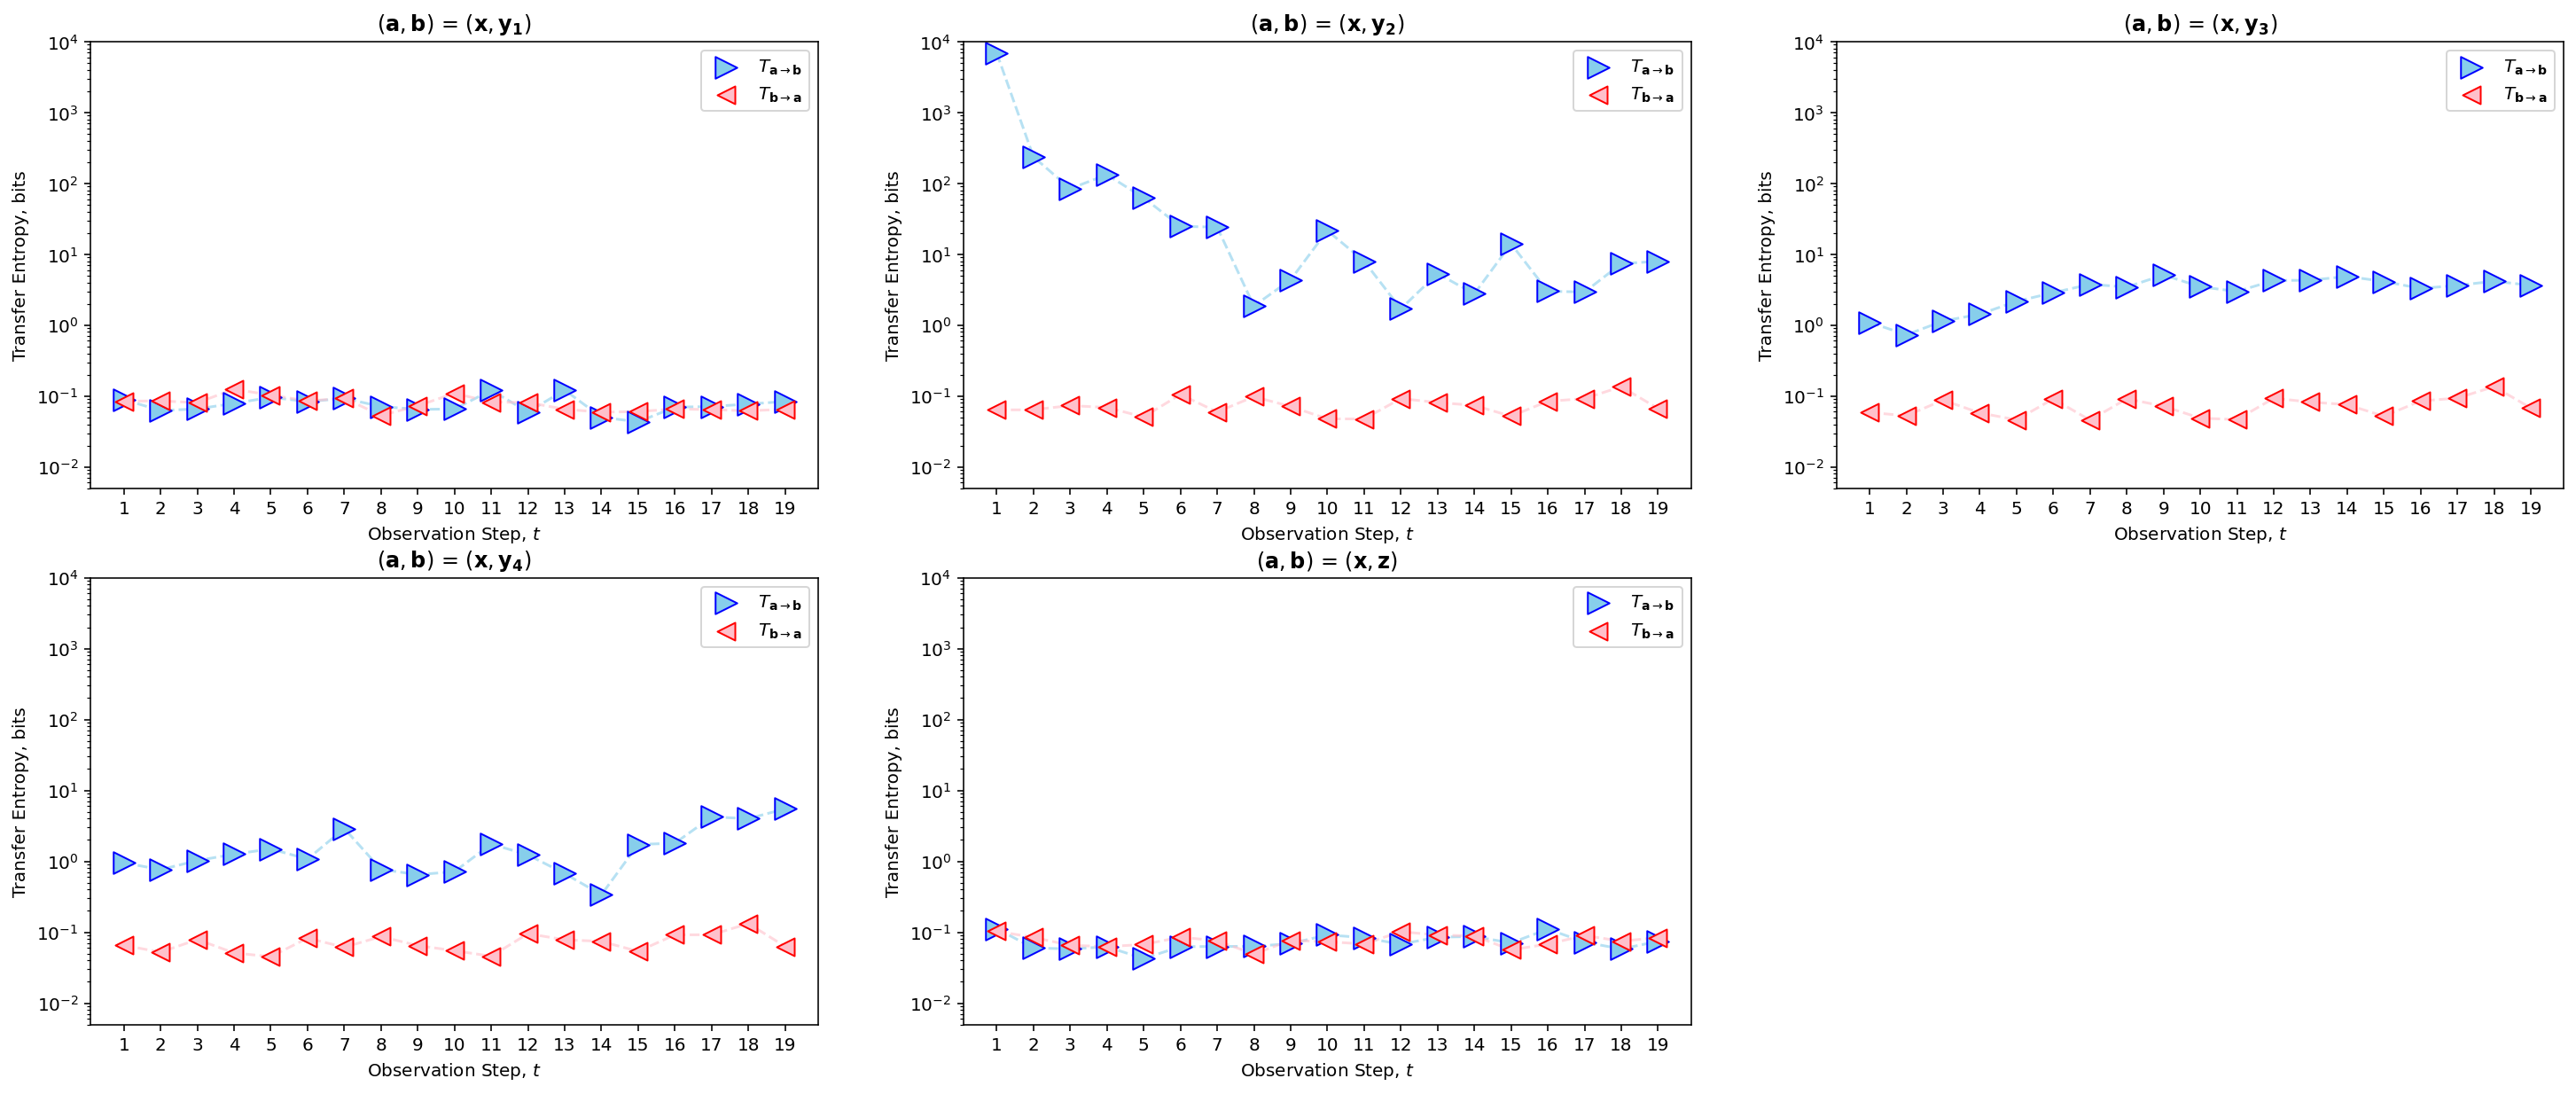

In [21]:
r,c=[2,3]
fig,axs=plt.subplots(r,c,figsize=(25,10),dpi=144)
idx_list=[[i,j] for i in range(r) for j in range(c)]
title_STR=[]
for k in range(len(TE_pairs)):
    pltid=idx_list[k]
    axs[pltid[0],pltid[1]].scatter(t_interest,TE_pairs[k][0],marker='>',s=150,color='skyblue',edgecolor='blue',label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
    axs[pltid[0],pltid[1]].plot(t_interest,TE_pairs[k][0],linestyle='--',color='skyblue',alpha=0.6,zorder=-1)
    axs[pltid[0],pltid[1]].scatter(t_interest,TE_pairs[k][1],marker='<',s=100,color='pink',edgecolor='red',label=r'$T_{\mathbf{b}\rightarrow\mathbf{a}}$')
    axs[pltid[0],pltid[1]].plot(t_interest,TE_pairs[k][1],linestyle='--',color='pink',alpha=0.6,zorder=-1)
    axs[pltid[0],pltid[1]].set_yscale('log')
    axs[pltid[0],pltid[1]].set_ylim([5e-3,1e4])
    axs[pltid[0],pltid[1]].set_xticks(t_interest)
    axs[pltid[0],pltid[1]].legend()
    axs[pltid[0],pltid[1]].set_xlabel(r'Observation Step, $t$')
    axs[pltid[0],pltid[1]].set_ylabel(r'Transfer Entropy, bits')
    title_str = r'$(\mathbf{a},\mathbf{b})$ = $(' + titles[k][0] + r',' + titles[k][1] + r')$'
    title_STR.append(title_str)
    axs[pltid[0],pltid[1]].set_title(title_str)
    #axs[pltid[0],pltid[1]].grid()
for l in range(k+1,len(idx_list)):
    pltid=idx_list[l]
    axs[pltid[0],pltid[1]].set_axis_off()

In [22]:
relation=['ElementWise','Linear','Quadratic','Cubic','Independent']
for i in range(len(relation)):
    print(f'{relation[i]} relation:')
    print(f'The a->b :{TE_pairs[i][0].mean()}')
    print(f'The b->a :{TE_pairs[i][1].mean()}')
    print(f'============================')

ElementWise relation:
The a->b :0.07722699249838123
The b->a :0.07885033930224937
Linear relation:
The a->b :395.8232019143289
The b->a :0.07517302649159215
Quadratic relation:
The a->b :3.1849620023114387
The b->a :0.07287399365940285
Cubic relation:
The a->b :1.730242841483658
The b->a :0.07217039746930362
Independent relation:
The a->b :0.07342262607206088
The b->a :0.07722075832982134


# Experiment 2: Implicit Historical Information Flow Detection

In [6]:


seqs=[y1,y2,y3,y4]
pairs=[[seqs[i],seqs[j]] for i in range(len(seqs)) for j in range(i+1,len(seqs))]



In [7]:
TE_pairs2=[]
tau=1
for pair in pairs:
    TE,t_interest=Transfer_Entropy_Sequence(pair[0],pair[1],tau=tau,n=16)
    TE_inv,_=Transfer_Entropy_Sequence(pair[1],pair[0],tau=tau,n=16)
    TE_pairs2.append([TE,TE_inv])

In [8]:
seq_names=[r'\mathbf{y_1}',r'\mathbf{y_2}',r'\mathbf{y_3}',r'\mathbf{y_4}']
titles=[[seq_names[i],seq_names[j]] for i in range(len(seq_names)) for j in range(i+1,len(seq_names))]

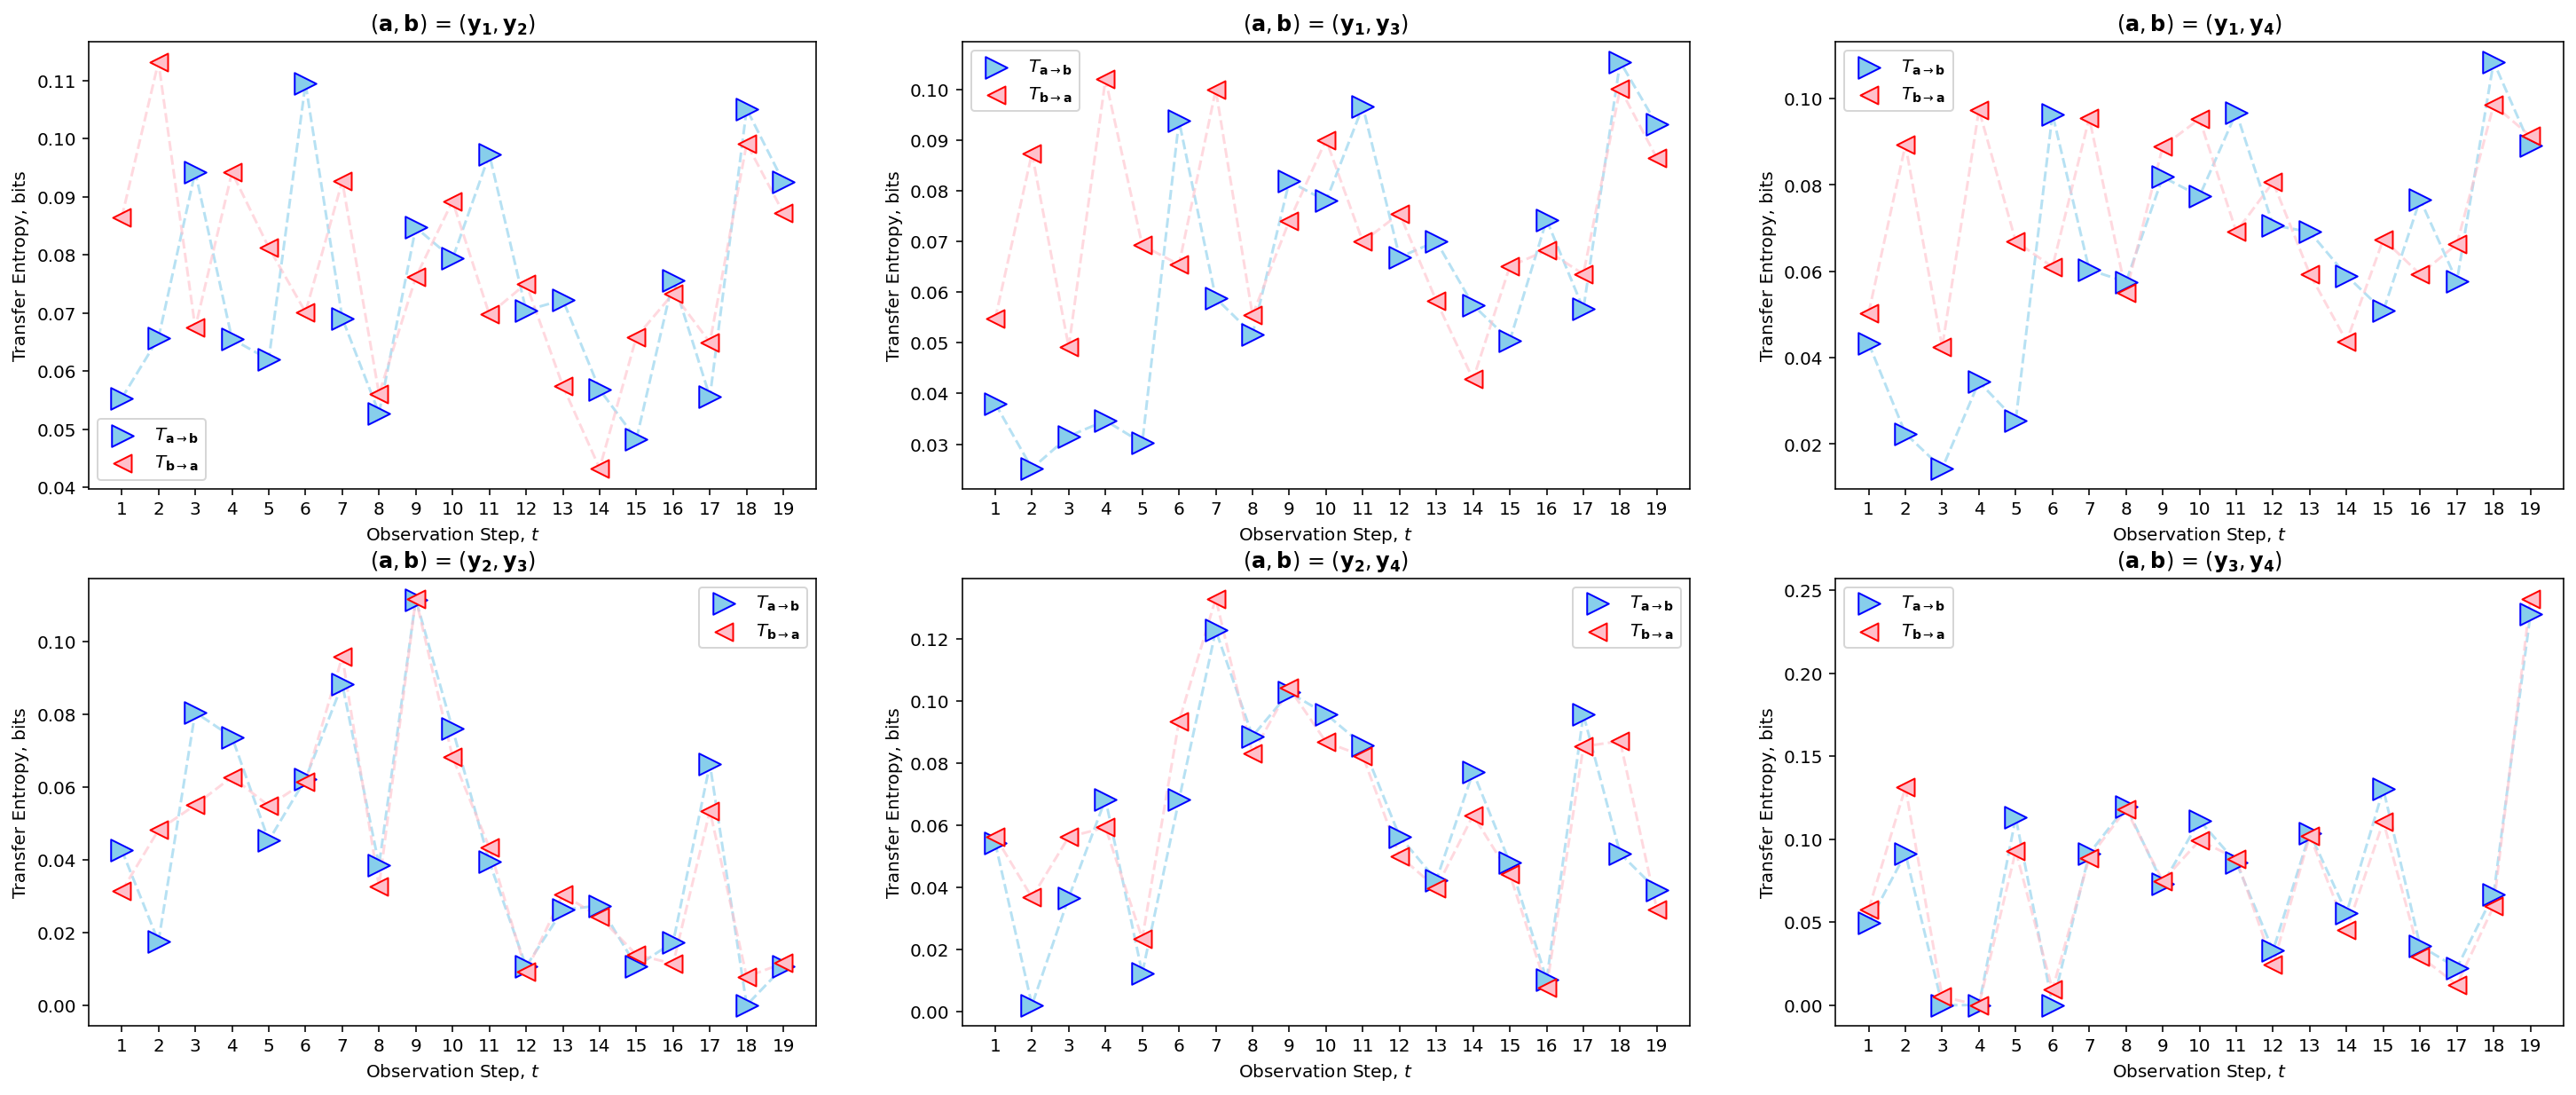

In [9]:
r,c=[2,3]
fig,axs=plt.subplots(r,c,figsize=(25,10),dpi=144)
idx_list=[[i,j] for i in range(r) for j in range(c)]
title_STR=[]
for k in range(len(TE_pairs2)):
    pltid=idx_list[k]
    axs[pltid[0],pltid[1]].scatter(t_interest,TE_pairs2[k][0],marker='>',s=150,color='skyblue',edgecolor='blue',label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
    axs[pltid[0],pltid[1]].plot(t_interest,TE_pairs2[k][0],linestyle='--',color='skyblue',alpha=0.6,zorder=-1)
    axs[pltid[0],pltid[1]].scatter(t_interest,TE_pairs2[k][1],marker='<',s=100,color='pink',edgecolor='red',label=r'$T_{\mathbf{b}\rightarrow\mathbf{a}}$')
    axs[pltid[0],pltid[1]].plot(t_interest,TE_pairs2[k][1],linestyle='--',color='pink',alpha=0.6,zorder=-1)
    #axs[pltid[0],pltid[1]].set_yscale('log')
    #axs[pltid[0],pltid[1]].set_ylim([0,1e1])
    axs[pltid[0],pltid[1]].set_xticks(t_interest)
    axs[pltid[0],pltid[1]].legend()
    axs[pltid[0],pltid[1]].set_xlabel(r'Observation Step, $t$')
    axs[pltid[0],pltid[1]].set_ylabel(r'Transfer Entropy, bits')
    title_str = r'$(\mathbf{a},\mathbf{b})$ = $(' + titles[k][0] + r',' + titles[k][1] + r')$'
    title_STR.append(title_str)
    axs[pltid[0],pltid[1]].set_title(title_str)
    #axs[pltid[0],pltid[1]].grid()
for l in range(k+1,len(idx_list)):
    pltid=idx_list[l]
    axs[pltid[0],pltid[1]].set_axis_off()

In [52]:
for i in range(len(titles)):
    print(f'{titles[i]} relation:')
    print(f'The a->b :{TE_pairs2[i][0].mean()}')
    print(f'The b->a :{TE_pairs2[i][1].mean()}')
    print(f'============================')

['\\mathbf{y_1}', '\\mathbf{y_2}'] relation:
The a->b :0.07433192823084409
The b->a :0.07700137637654492
['\\mathbf{y_1}', '\\mathbf{y_3}'] relation:
The a->b :0.06285612475907007
The b->a :0.07247225120765327
['\\mathbf{y_1}', '\\mathbf{y_4}'] relation:
The a->b :0.06273576350213354
The b->a :0.07253622895022346
['\\mathbf{y_2}', '\\mathbf{y_3}'] relation:
The a->b :0.04445854406704513
The b->a :0.04354835272719702
['\\mathbf{y_2}', '\\mathbf{y_4}'] relation:
The a->b :0.060907279655607945
The b->a :0.06446518109205442
['\\mathbf{y_3}', '\\mathbf{y_4}'] relation:
The a->b :0.07463970067014075
The b->a :0.07337687485006282


# Experiment 3: Statistical Permutatable Test

In [6]:
#A=np.array([[1,2,3],[4,5,6]])
def random_shuffle(A):
    """
    Randomly shuffle a sequential dataset along its temporal dimension.
    
    Parameters:
    - A: numpy array. The sequential data to be shuffled.
        For a 2D array (matrix), rows represent different sequences or variables,
        and columns represent time steps (temporal dimension).
        For a 1D array, it represents a single sequence of data over time.
    
    Returns:
    - numpy array: The shuffled array with the same shape as A.
    
    The function checks the dimensionality of A to determine how to shuffle:
    - If A is 2D (matrix), it shuffles the columns (time steps) while keeping the row order (sequences).
    - If A is 1D, it shuffles the array elements.
    - If A has an unsupported shape, it prints an 'Error shape' message.
    """
    if len(A.shape) == 2:  # If A is a 2D matrix
        return A[:, np.random.permutation(A.shape[1])]
    elif len(A.shape) == 1:  # If A is a 1D array
        return A[np.random.permutation(A.shape[0])]
    else:  # If A has an unsupported shape
        print('Error: Unsupported array shape.')

In [8]:
def Transfer_Entropy_Sequence_plus_permutable_test(source,target,tau=1,n=16,r=50,rho=0.9):
    """
    Extending Transfer_Entropy_Sequence with a permutation test for Transfer Entropy (TE) significance analysis.
    This function evaluates the significance of TE values by comparing against a distribution of TE values
    obtained from permuted source sequences, helping to filter out TE values likely resulting from random chance.
    
    Inputs:
        - source, target: Input sequences for TE calculation.
        - tau (int): Time delay for TE calculation, default is 1.
        - n (int): Number of Gauss-Legendre points, default is 16.
        - r (int): Number of permuted sequences for significance testing.
        - rho (float): Threshold probability to filter the TE values, between 0 and 1.
    
    Outputs:
        - original_TE (numpy array): Transfer entropy sequence before permutation test.
        - TE_purify (numpy array): Adjusted Transfer entropy sequence based on permutation test results.
        - cdf_te_values (numpy array): A list containing the Cumulative Distribution Function (CDF) values of TE, in temporal order.
        - t_interest (numpy array): Array of observed steps, mainly used for plotting.
    
    Note: This function assumes the presence of a pre-defined Transfer_Entropy_Sequence function for initial TE calculations.
    """
    permuted_sources=[random_shuffle(source) for i in range(r)]
    permuted_TEseqs_list=[Transfer_Entropy_Sequence(permuted_source,target,tau=tau,n=n)[0] for permuted_source in permuted_sources]
    permuted_TEseqs=np.stack(permuted_TEseqs_list)
    original_TE,t_interest=Transfer_Entropy_Sequence(source,target=target,tau=tau,n=n)

    cdf_te_values_list=[]
    for col in range(permuted_TEseqs.shape[-1]):
        kde_col=stats.gaussian_kde(permuted_TEseqs[:,col])
        #p_te_col=kde_col(original_TE[col])
        cdf_te_values_list.append(kde_col.integrate_box_1d(-np.inf, original_TE[col]))
    cdf_te_values=np.array(cdf_te_values_list)
    TE_purify=original_TE.copy()
    TE_purify[cdf_te_values<rho]=0
    return original_TE, TE_purify,cdf_te_values,t_interest

In [11]:
rho=0.9

In [16]:
original_TE, TE_purify,cdf_te_values,t_interest=Transfer_Entropy_Sequence_plus_permutable_test(x,z,tau=2,n=16,r=50,rho=0.9)

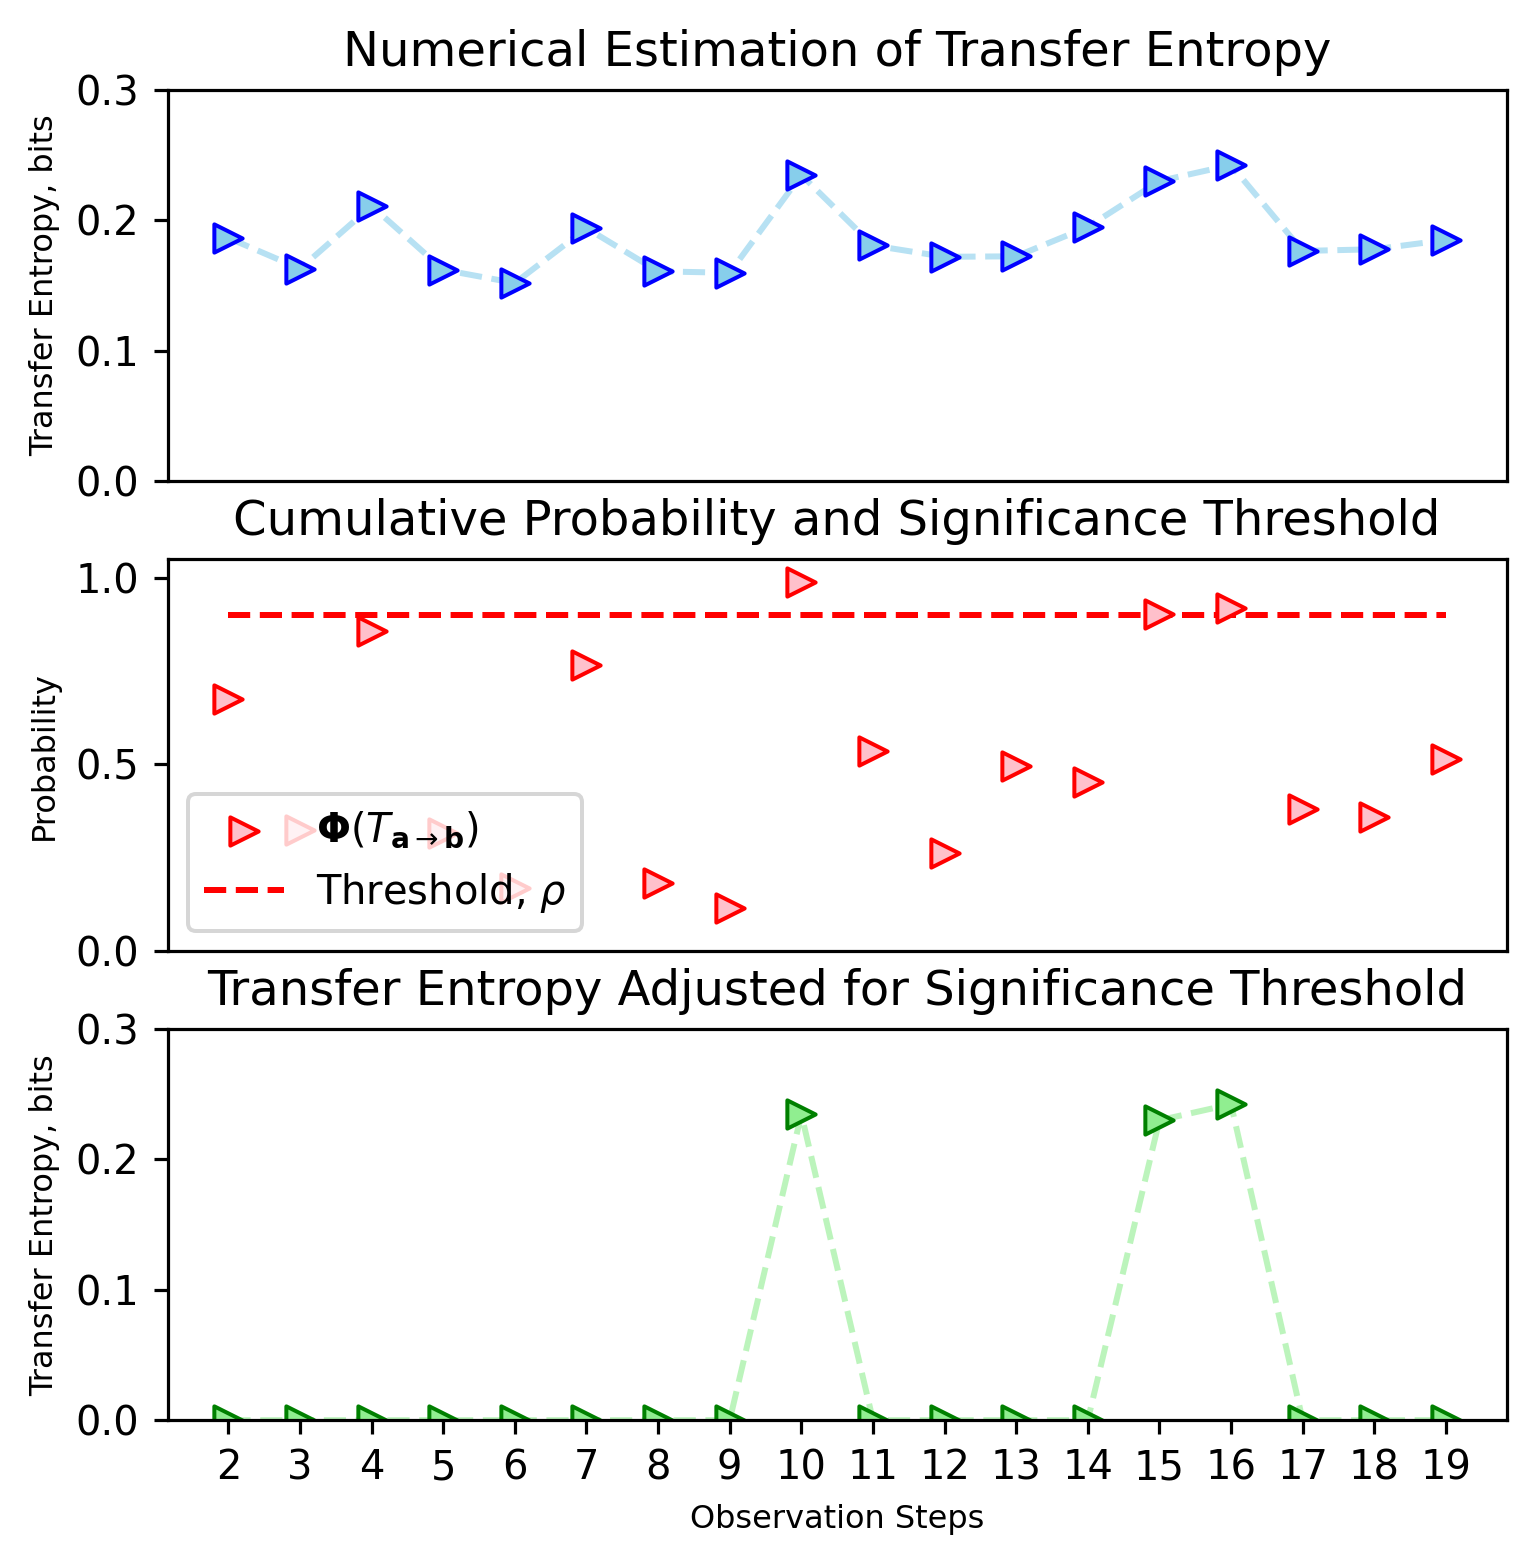

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6),dpi=288)
axs[0].scatter(t_interest,original_TE,marker='>',s=50,color='skyblue',edgecolor='blue',label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
axs[0].plot(t_interest,original_TE,linestyle='--',color='skyblue',alpha=0.6,zorder=-1)
axs[0].set_ylabel('Transfer Entropy, bits',fontsize=8)
axs[0].xaxis.set_visible(False)
axs[0].set_title('Numerical Estimation of Transfer Entropy')
axs[0].set_ylim([0,0.3])
axs[0].set_yticks([0.00,0.1,0.2,0.3])
#axs[0].set_yticks([0.00,2.5,5.0])

axs[1].scatter(t_interest,cdf_te_values,marker='>',s=50,color='pink',edgecolor='red',label=r'$\mathbf{\Phi}(T_{\mathbf{a}\rightarrow\mathbf{b}})$')
axs[1].plot(t_interest,rho*np.ones_like(t_interest),linestyle='--',color='red',alpha=1,zorder=-1,label=r'Threshold, $\rho$')
axs[1].set_ylabel('Probability',fontsize=8)
axs[1].xaxis.set_visible(False)
axs[1].legend(loc=3)
axs[1].set_ylim([0,1.05])
#axs[1].set_yticks([0.00,0.25,0.75,1])
axs[1].set_title('Cumulative Probability and Significance Threshold')


axs[2].scatter(t_interest,TE_purify,marker='>',s=50,color='lightgreen',edgecolor='green',label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
axs[2].plot(t_interest,TE_purify,linestyle='--',color='lightgreen',alpha=0.6,zorder=-1)
axs[2].set_ylabel('Transfer Entropy, bits',fontsize=8)
axs[2].set_xlabel('Observation Steps',fontsize=8)
axs[2].set_xticks(t_interest)
axs[2].set_title('Transfer Entropy Adjusted for Significance Threshold')
axs[2].set_ylim([0,0.3])
axs[2].set_yticks([0.00,0.1,0.2,0.3])
#axs[2].set_yticks([0.00,2.5,5.0])

# 散裝編程

In [28]:
#B=np.array([1,2,3,4,5,6])
#random_shuffle(B)
source=x
target=y3
r=50
permuted_sources=[random_shuffle(source) for i in range(r)]
permuted_TEseqs_list=[Transfer_Entropy_Sequence(permuted_source,target,tau=1,n=16)[0] for permuted_source in permuted_sources]
permuted_TEseqs=np.stack(permuted_TEseqs_list)
original_TE,t_interest=Transfer_Entropy_Sequence(source,target=target,tau=1,n=16)
#Obtain CDF for each column in permuted_TEseqs

#Plug the entries in original_TE to decide which step TE should be 0

In [29]:
#col=7
cdf_te_values_list=[]
for col in range(permuted_TEseqs.shape[-1]):
    kde_col=stats.gaussian_kde(permuted_TEseqs[:,col])
    #p_te_col=kde_col(original_TE[col])
    cdf_te_values_list.append(kde_col.integrate_box_1d(-np.inf, original_TE[col]))
cdf_te_values=np.array(cdf_te_values_list)
# Now how do I get the cdf value cdf_te_col from kde_col? Is it possible?

In [30]:
alpha=0.1
TE_purify=original_TE.copy()
TE_purify[cdf_te_values<(1-alpha)]=0

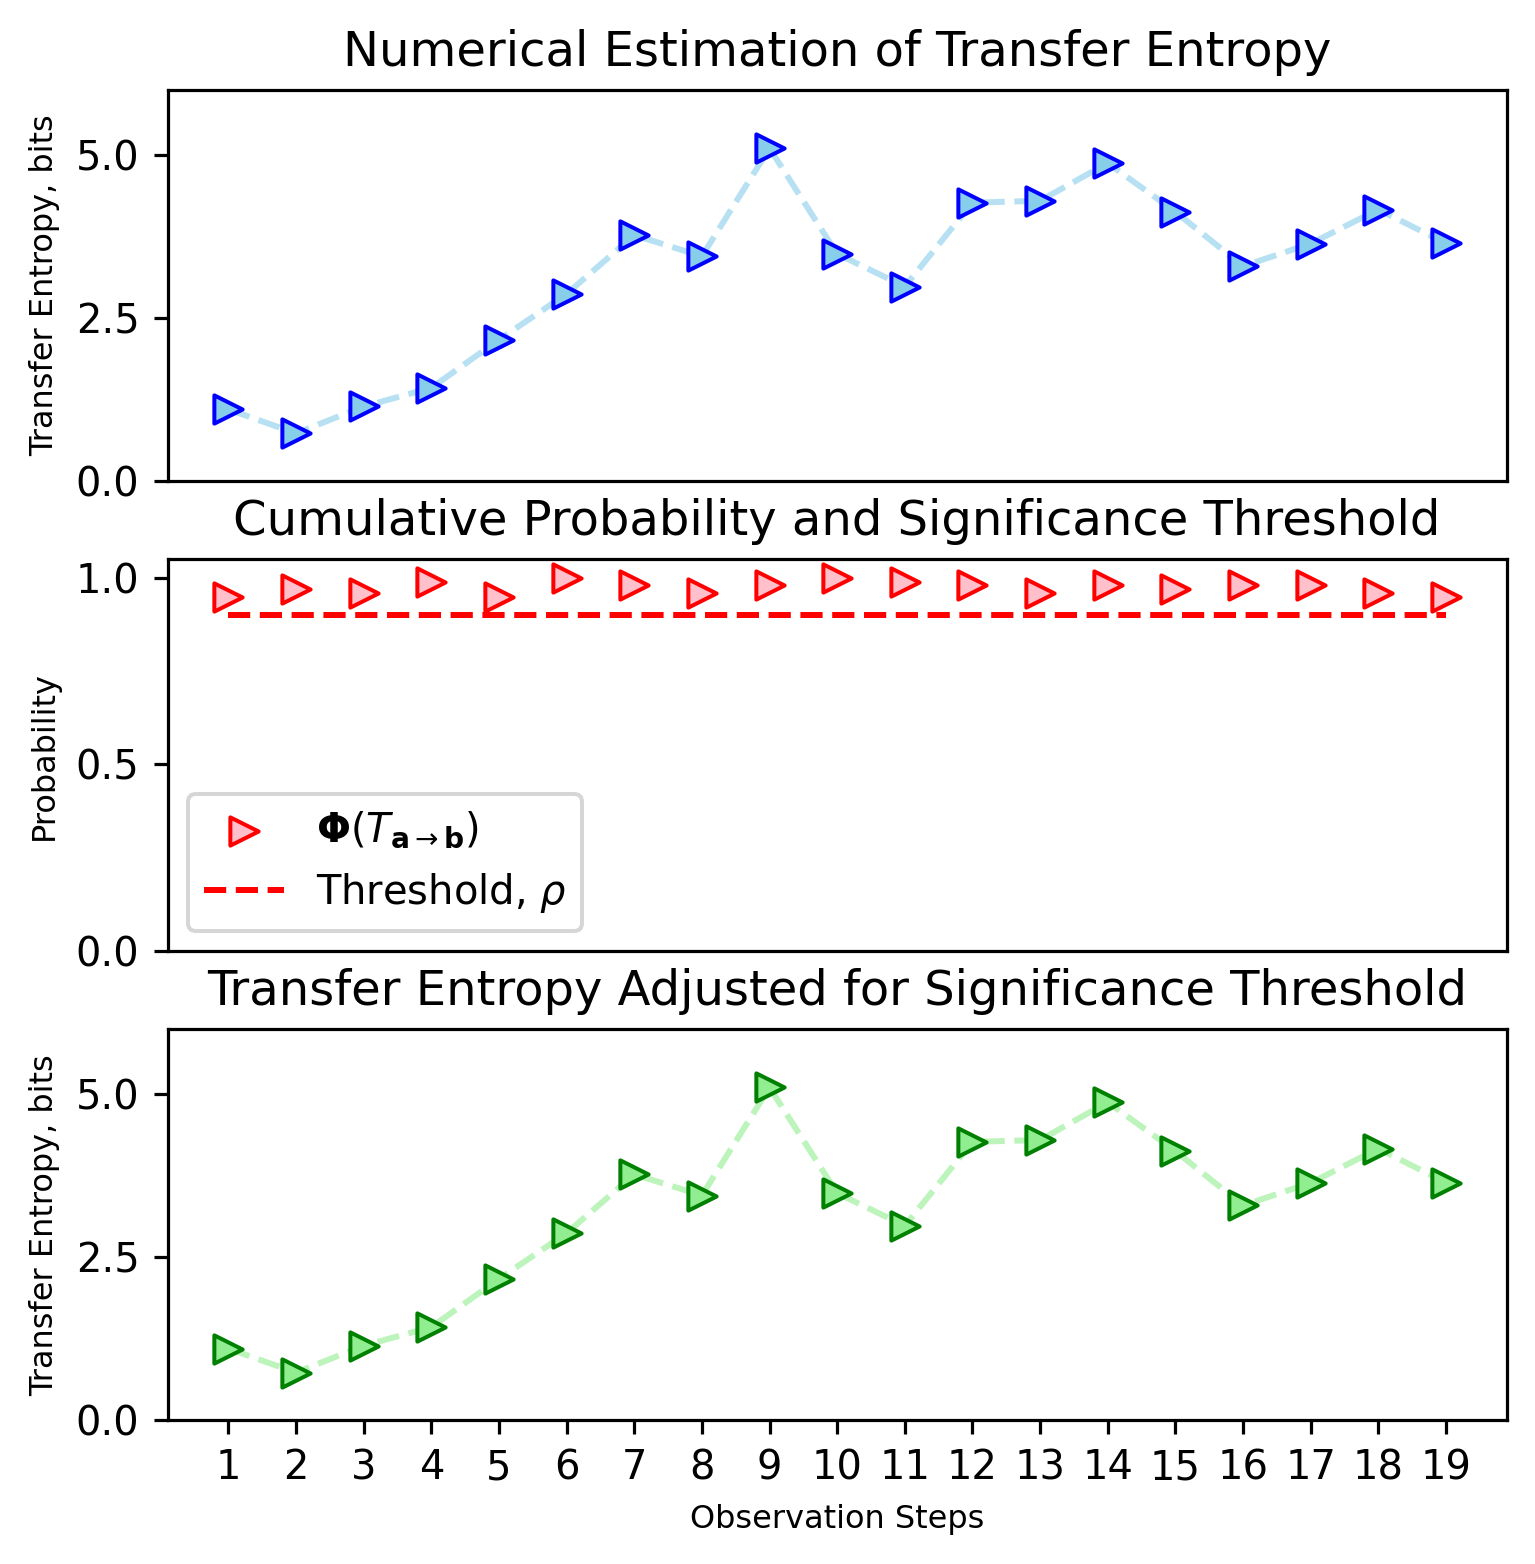

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6),dpi=288)
axs[0].scatter(t_interest,original_TE,marker='>',s=50,color='skyblue',edgecolor='blue',label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
axs[0].plot(t_interest,original_TE,linestyle='--',color='skyblue',alpha=0.6,zorder=-1)
axs[0].set_ylabel('Transfer Entropy, bits',fontsize=8)
axs[0].xaxis.set_visible(False)
axs[0].set_title('Numerical Estimation of Transfer Entropy')
axs[0].set_ylim([0,6])
#axs[0].set_yticks([0.00,0.1,0.2])
axs[0].set_yticks([0.00,2.5,5.0])

axs[1].scatter(t_interest,cdf_te_values,marker='>',s=50,color='pink',edgecolor='red',label=r'$\mathbf{\Phi}(T_{\mathbf{a}\rightarrow\mathbf{b}})$')
axs[1].plot(t_interest,(1-alpha)*np.ones_like(t_interest),linestyle='--',color='red',alpha=1,zorder=-1,label=r'Threshold, $\rho$')
axs[1].set_ylabel('Probability',fontsize=8)
axs[1].xaxis.set_visible(False)
axs[1].legend(loc=3)
axs[1].set_ylim([0,1.05])
#axs[1].set_yticks([0.00,0.25,0.75,1])
axs[1].set_title('Cumulative Probability and Significance Threshold')


axs[2].scatter(t_interest,TE_purify,marker='>',s=50,color='lightgreen',edgecolor='green',label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
axs[2].plot(t_interest,TE_purify,linestyle='--',color='lightgreen',alpha=0.6,zorder=-1)
axs[2].set_ylabel('Transfer Entropy, bits',fontsize=8)
axs[2].set_xlabel('Observation Steps',fontsize=8)
axs[2].set_xticks(t_interest)
axs[2].set_title('Transfer Entropy Adjusted for Significance Threshold')
axs[2].set_ylim([0,6])
#axs[2].set_yticks([0.00,0.1,0.2])
axs[2].set_yticks([0.00,2.5,5.0])

# Appendix: Test for Gauss point number

In [66]:
import time
tau=1
t_list=[1,3,5,7,9,11,13,15,17]
#t=1
source=x
target=y3
tests_points=[2,4,8,16,32,64,128,256,512]

te_over_time=[]
all_cost=[]
for t in t_list:
    print(f'process:{t+1}')
    cost=[]
    te_over_num_points=[]
    for n_ in tests_points:
        start_time = time.time()
        te_over_num_points.append(TEttau(source,target,t,tau,n=n_))
        cost.append(time.time() - start_time)
    te_over_time.append(te_over_num_points)
    all_cost.append(cost)

process:2
process:4
process:6
process:8
process:10
process:12
process:14
process:16
process:18


In [142]:

convergence_dat={'source':source,'Targets':target,'observed_time':t_list,'gauss_points':tests_points,'TE_values':te_over_time,'costs':all_cost}


with open('TE_convergence_test.pkl', 'wb') as f:
    pickle.dump(convergence_dat, f)

In [124]:
costs=np.stack(all_cost)
xbasis=np.linspace(1,costs.shape[-1],costs.shape[-1])

Text(0, 0.5, 'Time Cost for Single Step TE Estimation, sec')

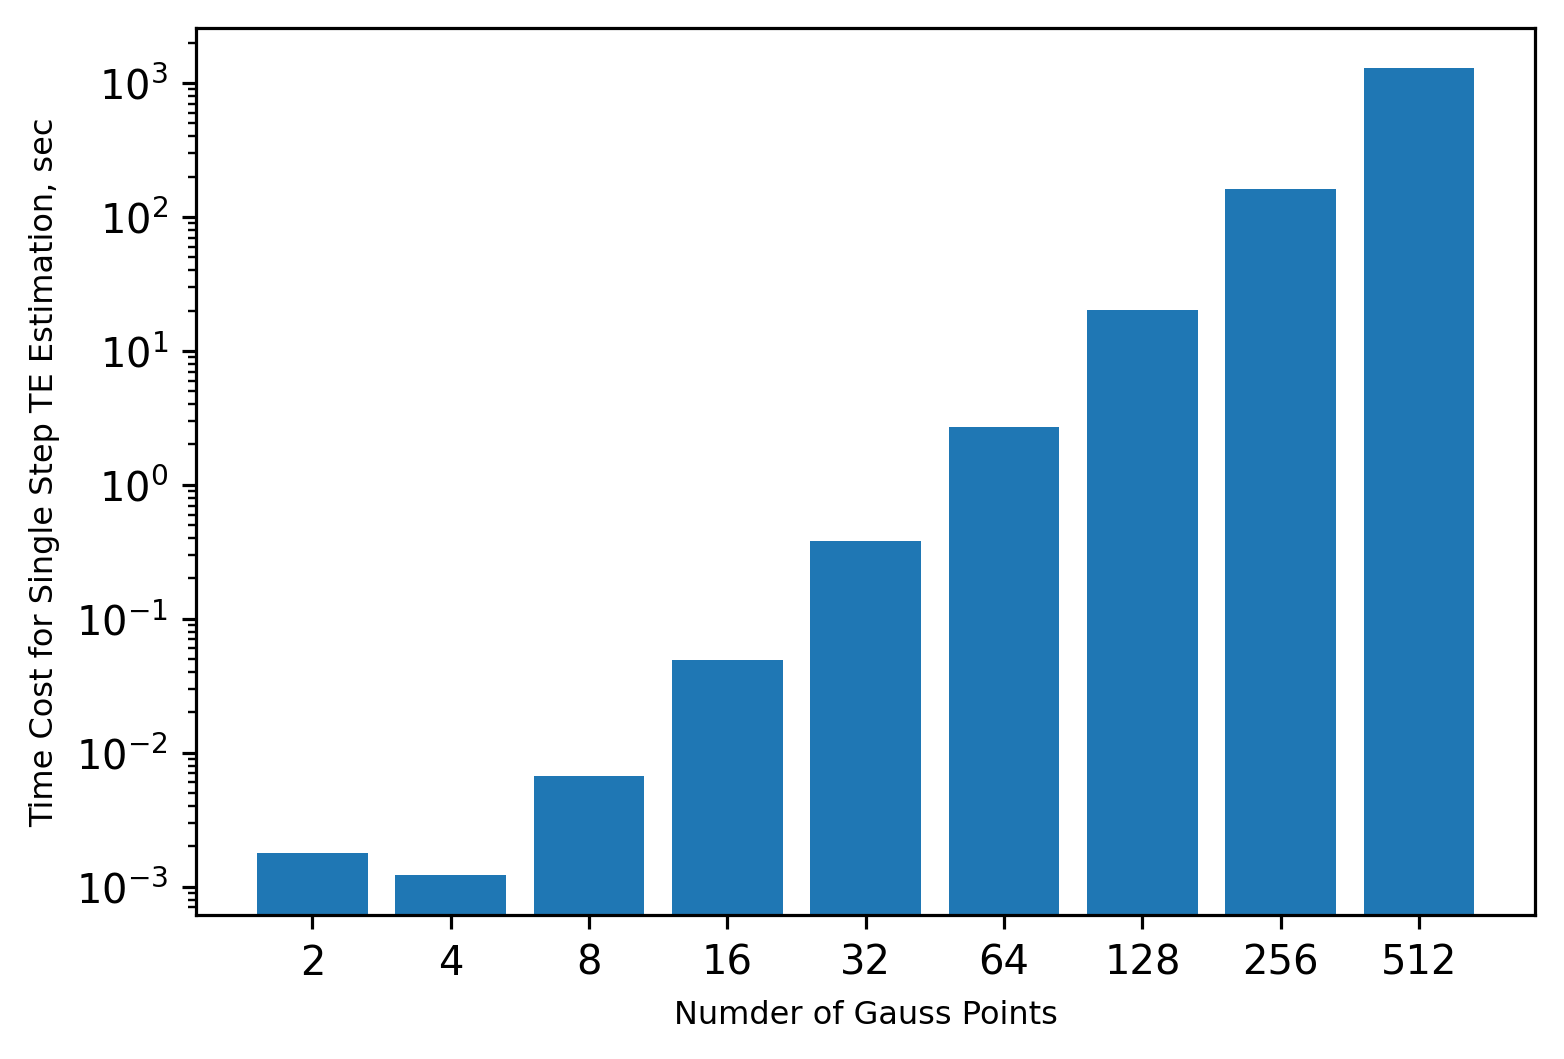

In [140]:
plt.figure(figsize=(6,4),dpi=288)
plt.bar(xbasis,costs.mean(0))
plt.xticks(xbasis,tests_points)
plt.yscale('log')
plt.xlabel('Numder of Gauss Points',fontsize=8)
plt.ylabel('Time Cost for Single Step TE Estimation, sec',fontsize=8)

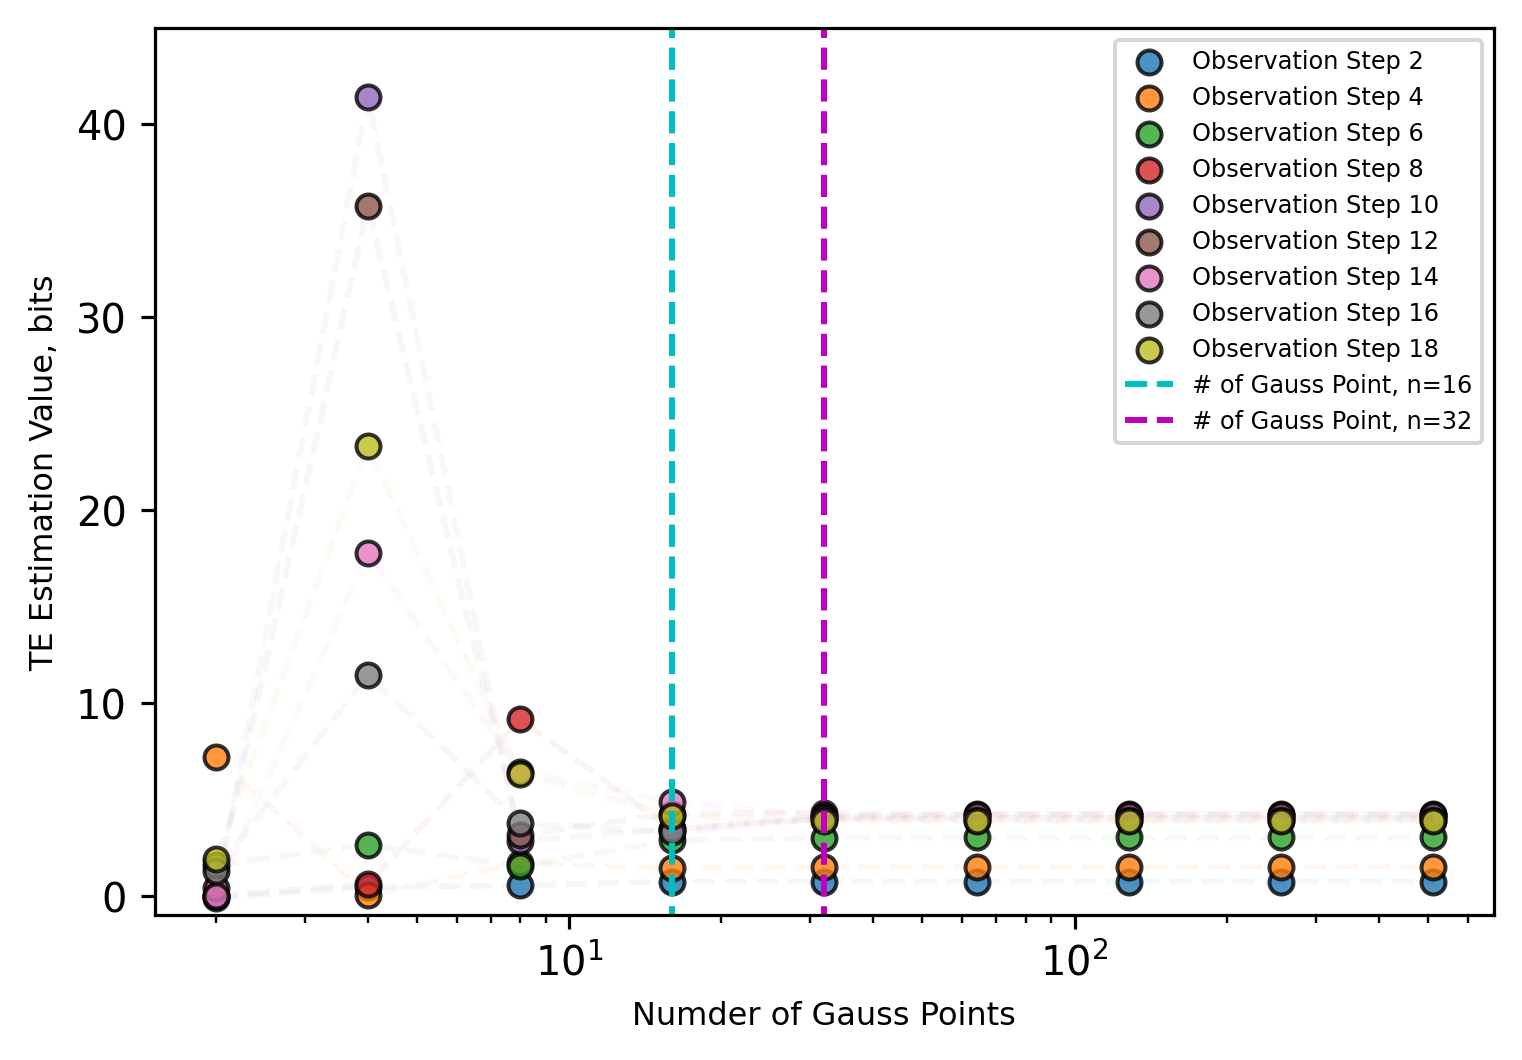

In [139]:
plt.figure(figsize=(6,4),dpi=288)
for idx,te_over_num_points in enumerate(te_over_time):
    plt.scatter(tests_points,te_over_num_points,edgecolors='k',alpha=0.8,label='Observation Step '+str(t_list[idx]+1))
    plt.plot(tests_points,te_over_num_points,'--',alpha=0.05)
    
    plt.xscale('log')
    
plt.plot(np.ones(2)*16,[-5,50],'--',color='c',label='# of Gauss Point, '+r'n=16')
plt.plot(np.ones(2)*32,[-5,50],'--',color='m',label='# of Gauss Point, '+r'n=32')
plt.ylim([-1,45])
#.xticks(tests_points)
plt.xlabel('Numder of Gauss Points',fontsize=8)
plt.ylabel('TE Estimation Value, bits',fontsize=8)
plt.legend(fontsize=6)

In [95]:
tests_points

[2, 4, 8, 16, 32, 64, 128, 256, 512]

In [215]:
tau=1
t=1
T=x.shape[-1]
transfer_entropy_values2=[]
t_interval=[]

#for t in range(tau-1,T-1):
ytp1=y1[:,[t+1]]
yttau=y1[:,t-tau+1:t+1]
xttau=x[:,t-tau+1:t+1]
TEint=Conditional_Entropy(ytp1,xttau,yttau)

In [49]:
# Single pair calculation
source=x
target=z

In [50]:
TE,t_interest=Transfer_Entropy_Sequence(source,target,tau=1,n=16)
#sourcemm=(source-source.min())/(source.max()-source.min())
#targetmm=(target-target.min())/(target.max()-target.min())
#TEmm,_=Transfer_Entropy_Sequence(sourcemm,targetmm,tau=1,n=16)
#sourcez=(source-source.mean())/source.std()
#targetz=(target-target.mean())/target.std()

#TEzc,_=Transfer_Entropy_Sequence(sourcez,targetz,tau=1,n=16)
TE_inv,_=Transfer_Entropy_Sequence(target,source,tau=1,n=16)

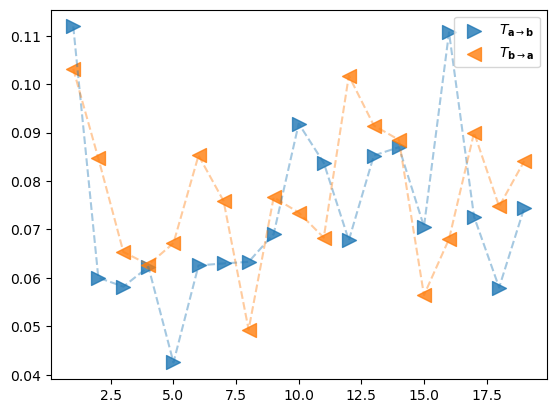

In [51]:


plt.scatter(t_interest,TE,marker='>',s=100,alpha=0.8,label=r'$T_{\mathbf{a}\rightarrow\mathbf{b}}$')
plt.plot(t_interest,TE,linestyle='--',alpha=0.4)
plt.scatter(t_interest,TE_inv,marker='<',s=100,alpha=0.8,label=r'$T_{\mathbf{b}\rightarrow\mathbf{a}}$')
plt.plot(t_interest,TE_inv,linestyle='--',alpha=0.4)
plt.legend()

#plt.plot(t_interest,TEzc,linestyle='--', marker='p',label='Z-Score Normalization')
#plt.yscale('log')

In [ ]:


source=y1
target=y2
T=source.shape[-1]
transfer_entropy_values=[]
t_interval=[]

taus=[1,2,3]
for tan in taus:
    ytp1=target[:,[t+1]]
    yttau=target[:,t-tau+1:t+1]
    xttau=source[:,t-tau+1:t+1]
    big_joint = np.hstack([ytp1, xttau, yttau])   
    print(big_joint.shape)    


In [84]:
TE.mean()

0.07643817398068505

In [85]:
# First select tau, then t ``must begins from t=tau-1 and end at T-1, i.e., for t in range(tau-1,T-1)
tau=1
#t=3
T=x.shape[-1]
transfer_entropy_values = []
transfer_entropy_values2=[]
t_interval=[]

for t in range(tau-1,T-1):
    ytp1=y1[:,[t+1]]
    yttau=y1[:,t-tau+1:t+1]
    xttau=x[:,t-tau+1:t+1]
    # Compute the four joint entropies needed for transfer entropy
    H_yt1_yttau = Joint_Entropy(np.hstack([ytp1, yttau]),n=16)
    H_yttau = Joint_Entropy(yttau,n=16)
    H_yt1_yttau_xttau = Joint_Entropy(np.hstack([ytp1, yttau, xttau]),n=16)
    H_yttau_xttau = Joint_Entropy(np.hstack([yttau, xttau]),n=16)
    ## Calculate the transfer entropy
    TE = H_yt1_yttau - H_yttau - (H_yt1_yttau_xttau - H_yttau_xttau)
    TEint=Conditional_Entropy(ytp1,xttau,yttau)
    transfer_entropy_values.append(TE)
    transfer_entropy_values2.append(TEint)
    t_interval.append(t+1)
transfer_entropy_values=np.array(transfer_entropy_values)
transfer_entropy_values=np.maximum(transfer_entropy_values,1e-12)

0.11129643146272497

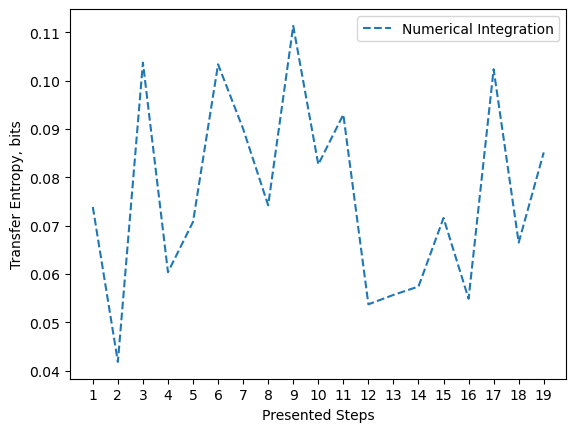

In [86]:
#plt.plot(t_interval,transfer_entropy_values,'--',label='Entropy Operation')
plt.plot(t_interval,transfer_entropy_values2,'--',label='Numerical Integration')
plt.xticks(t_interval)
#plt.ylim([0,0.3])
plt.ylabel(r'Transfer Entropy, bits')
plt.xlabel(r'Presented Steps')
plt.legend()
max(transfer_entropy_values2)

In [185]:
transfer_entropy_values2

[0.4108473976782001,
 0.41597331795635556,
 0.5859882454340093,
 0.9666019408893183,
 1.6098478610143145,
 1.3985700255522473,
 1.4601792612168418,
 1.6465573350747373,
 1.7975896524733677,
 1.157818567292466,
 1.8558393955267332,
 1.338550099986497,
 1.4496839053437354,
 1.4539352623588386,
 1.4129451681757748,
 1.3918046405167321,
 1.2742056833756357,
 1.2456806659323139,
 1.5439096174611613]

In [ ]:
tau=1
t=1
ytp1=y1[:,[t+1]]
yttau=y1[:,t-tau+1:t+1]
xttau=x[:,t-tau+1:t+1]

In [102]:
#Cat and kde

big_joint=np.hstack([ytp1,xttau, yttau])
small_j1=np.hstack([ytp1, yttau])
small_j2=np.hstack([xttau, yttau])
#kdes
kde_bj=stats.gaussian_kde(big_joint.T)
kdey_tau=stats.gaussian_kde(yttau.T)
kde_s1=stats.gaussian_kde(small_j1.T)
kde_s2=stats.gaussian_kde(small_j2.T)

In [12]:
#Gauss points and weights
n=16
upper,lower=[big_joint.max(0),big_joint.min(0)]
buffer=0.3*(upper-lower)
glpw,_=GLJointNW_general(N=[n for i in range(big_joint.shape[-1])],Lower=lower-buffer,Upper=upper+buffer)




In [13]:
d_ytp1, d_xtau, d_ytau = [ytp1.shape[-1], xttau.shape[-1], yttau.shape[-1]]  # dimensions [1, 2, 2]
#Extract corresponding points:
gauss_bigjoint=glpw[:,:-1]
gaussp_ytau=glpw[:, d_ytp1+d_xtau:d_ytp1+d_xtau+d_ytau] # Points for ytau
gauss_sj1=np.hstack([glpw[:,0:d_ytp1],glpw[:, d_ytp1+d_xtau:d_ytp1+d_xtau+d_ytau]]) # Joint points for ytp1 and ytau
gauss_sj2=np.hstack([glpw[:, d_ytp1:d_ytp1+d_xtau],glpw[:, d_ytp1+d_xtau:d_ytp1+d_xtau+d_ytau]]) # Joint points for xtau and ytau
w=glpw[:,-1] # Gauss weight
pbj=kde_bj(gauss_bigjoint.T)
pytau=kdey_tau(gaussp_ytau.T)
ps1=kde_s1(gauss_sj1.T)
ps2=kde_s2(gauss_sj2.T)

In [14]:
(pbj*( np.log2(pytau)+np.log2(pbj)-np.log2(ps1)-np.log2(ps2) )*w).sum()

0.6045397352380412

In [15]:
adj_pbj=np.maximum(pbj,1e-12)

(pbj*w).sum()
(adj_pbj*w).sum()

0.9972485480459348

In [105]:
#Check indexing of Splitting
d_ytp1, d_xtau, d_ytau = [ytp1.shape[-1], xttau.shape[-1], yttau.shape[-1]]  # dimensions [1, 2, 2]

# Extract ytp1
extracted_ytp1 = big_joint[:, 0:d_ytp1]

# Extract xttau
extracted_xttau = big_joint[:, d_ytp1:d_ytp1+d_xtau]

# Extract yttau
extracted_yttau = big_joint[:, d_ytp1+d_xtau:d_ytp1+d_xtau+d_ytau]

print((extracted_ytp1==ytp1).all())
print((extracted_xttau==xttau).all())
print((extracted_yttau==yttau).all())

True
True
True


In [ ]:
gaussp_ytau = glpw[:, d_ytp1+d_xtau:d_ytp1+d_xtau+d_ytau] # y_t^tau
gauss_sj1 = np.hstack([glpw[:, :d_ytp1], gaussp_ytau]) # [y_{t+1},y_t^tau]
gauss_sj2 = np.hstack([glpw[:, d_ytp1:d_ytp1+d_xtau], gaussp_ytau]) #[x_t^tau, y_t^tau]

In [43]:
print(big_joint.shape)
print(ytp1.shape)
print(xttau.shape)
print(yttau.shape)

(100, 5)
(100, 1)
(100, 2)
(100, 2)


([<matplotlib.axis.XTick at 0x291309f8400>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

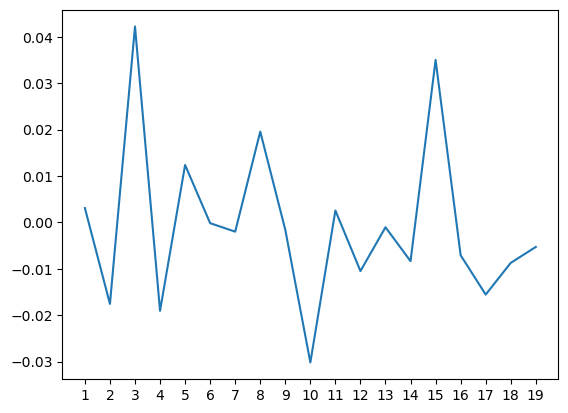

np.hstack([ytp1,yttau])# Joint_Entropy(np.hstack([ytp1,yttau]))
yttau# Joint_Entropy(yttau)
np.hstack([ytp1,yttau,xttau])# Joint_Entropy(np.hstack([ytp1,yttau,xttau]))
np.hstack([yttau,xttau])# Joint_Entropy(np.hstack([yttau,xttau]))

In [8]:
# Compute the four joint entropies needed for transfer entropy
H_yt1_yttau = Joint_Entropy(np.hstack([ytp1, yttau]),n=16)
H_yttau = Joint_Entropy(yttau,n=16)
H_yt1_yttau_xttau = Joint_Entropy(np.hstack([ytp1, yttau, xttau]),n=16)
H_yttau_xttau = Joint_Entropy(np.hstack([yttau, xttau]),n=16)

# Calculate the transfer entropy
TE = H_yt1_yttau - H_yttau - (H_yt1_yttau_xttau - H_yttau_xttau)
TE

-0.005279729876546568

In [74]:
a=[1,2,3,4,5,6,7,8,9,10]
t=1
tau=2
T=len(a)
for t in range(tau-1,T-1):
    print(a[t-tau+1:t+1])

[1, 2]
[2, 3]
[3, 4]
[4, 5]
[5, 6]
[6, 7]
[7, 8]
[8, 9]
[9, 10]


In [109]:
n=16
joint=np.hstack([ytp1, yttau, xttau])
big_kde=stats.gaussian_kde(joint.T)

upper,lower=[joint.max(0),joint.min(0)]
buffer=0.3*(upper-lower)
gauss_pw,_=GLJointNW_general(N=[n for i in range(joint.shape[-1])], Lower=lower-buffer,Upper=upper+buffer)

In [110]:
w=gauss_pw[:,-1]
(big_kde(gauss_pw[:,:-1].T)*w).sum()

0.9989541296719859